In [1]:
import numpy as np
import os
from os import walk
import soundfile
import librosa
import librosa.display
import matplotlib.pyplot as plt
import random
import IPython.display as ipd

from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import tqdm


/Users/johannasmriti/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def get_filepaths(directory = "/Users/johannasmriti/Downloads/musicnet/Denoising_Audio/noise_data_clean"):
    filepaths = []

    for root, dirs, files in os.walk("/Users/johannasmriti/Downloads/musicnet/Denoising_Audio/noise_data_clean", topdown=False):
        for name in files:
            filepaths.append(os.path.join(root, name))
    if directory == "/Users/johannasmriti/Downloads/musicnet/Denoising_Audio/noise_data_clean":
        filepaths = filepaths[:-1]
    
    return filepaths

In [3]:
filepaths = get_filepaths()

print(len(filepaths), 'audio files in the dataset.')

4100 audio files in the dataset.


In [4]:
data, sample_rate = librosa.load(filepaths[0], sr = None)
print('Duration:', len(data)/sample_rate, 's')
ipd.Audio(filepaths[0])

Duration: 5.0 s


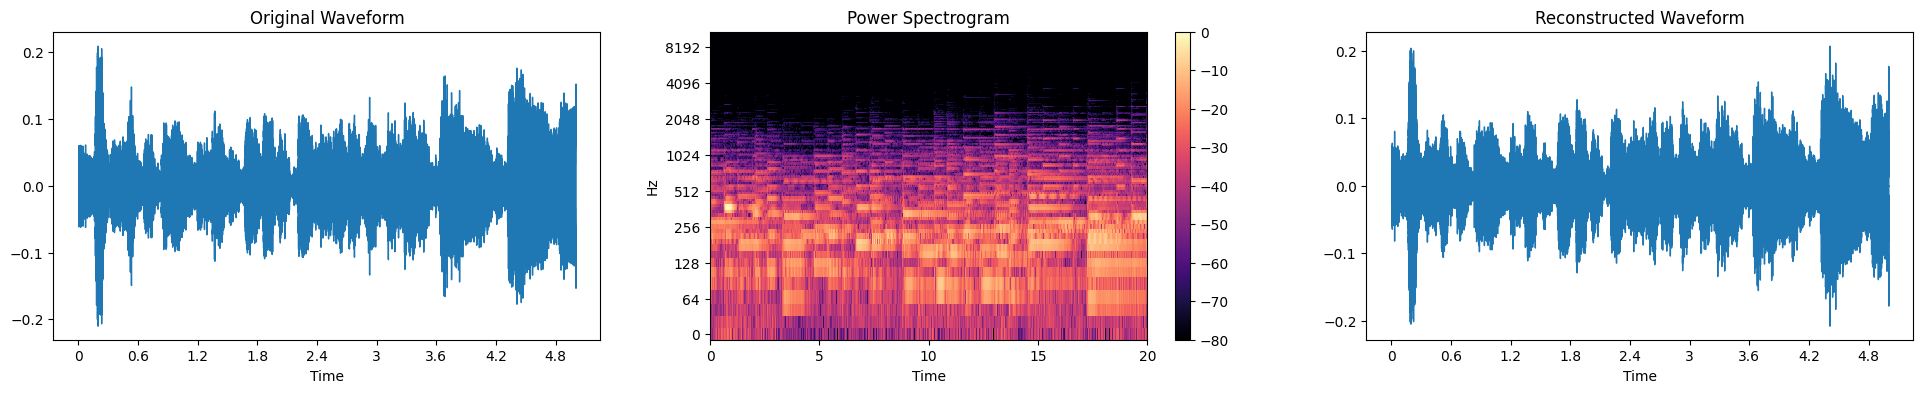

In [5]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf

S = np.abs(librosa.stft(data, n_fft=1024))

data_inv = librosa.griffinlim(S)

if len(data_inv) < len(data):
    data_inv = np.pad(data_inv, (0, len(data) - len(data_inv)))  
elif len(data_inv) > len(data):
    data_inv = data_inv[:len(data)]  
    
fig, ax = plt.subplots(ncols=3, figsize=(24, 4))

librosa.display.waveshow(data, sr=sample_rate, ax=ax[0])
ax[0].set_title('Original Waveform')

img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax[1])
ax[1].set_title('Power Spectrogram')
fig.colorbar(img, ax=ax[1])

librosa.display.waveshow(data_inv, sr=sample_rate, ax=ax[2])
ax[2].set_title('Reconstructed Waveform')

plt.show()



In [6]:

sf.write('griffinlim_example.wav', data_inv, sample_rate)

import IPython.display as ipd
ipd.Audio('griffinlim_example.wav')

In [7]:
import librosa

print(f"Original audio duration: {librosa.get_duration(y=data, sr=sample_rate)} seconds")
print(f"Reconstructed audio duration: {librosa.get_duration(y=data_inv, sr=sample_rate)} seconds")


Original audio duration: 5.0 seconds
Reconstructed audio duration: 5.0 seconds


In [8]:
RMS=np.sqrt(np.mean(np.abs(data**2)))
noise=np.random.normal(0, RMS, data.shape[0])
data_noisy = data+noise

In [9]:
soundfile.write('noisy_example.wav', data_noisy, sample_rate)
ipd.Audio('./noisy_example.wav')

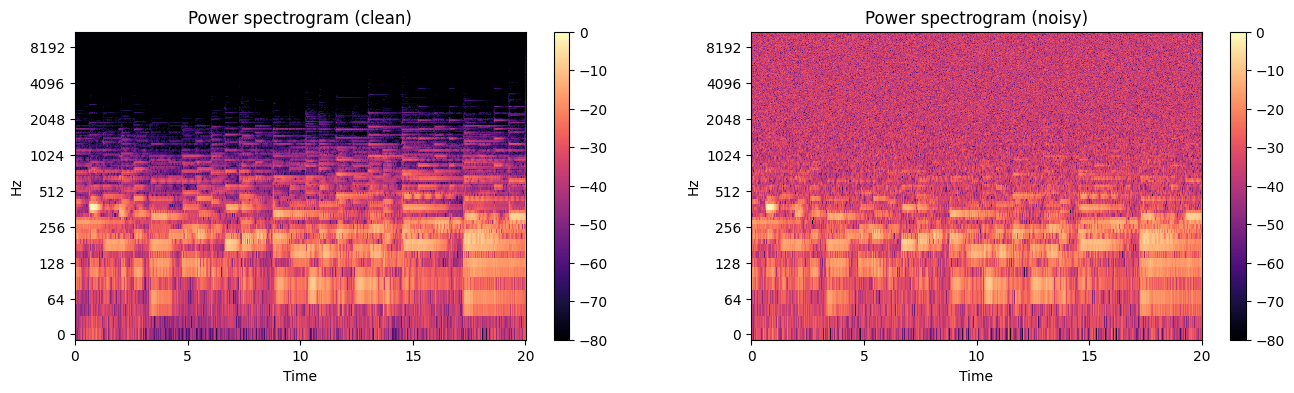

In [10]:
S_noisy = np.abs(librosa.stft(data_noisy, n_fft=1024))

fig, ax = plt.subplots(ncols=2, figsize = (16,4))

img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax[0])
ax[0].set_title('Power spectrogram (clean)')
fig.colorbar(img, ax=ax[0])

img = librosa.display.specshow(librosa.amplitude_to_db(S_noisy, ref=np.max), y_axis='log', x_axis='time', ax=ax[1])
ax[1].set_title('Power spectrogram (noisy)')
fig.colorbar(img, ax=ax[1])

plt.show()

In [11]:
def inspect_spectrogram_shapes(filepaths, duration_s=5, sample_rate=22050):
    X_clean = []
    X_noisy = []

    duration = int(sample_rate * duration_s)  
    
    for filepath in filepaths:
        data, _ = librosa.load(filepath, sr=sample_rate)
        if len(data) < duration:
            max_offset = np.abs(len(data) - duration)
            offset = np.random.randint(max_offset)
            data = np.pad(data, (offset, duration-len(data)-offset), "constant")
        
        elif len(data) > duration:
            max_offset = np.abs(len(data) - duration)
            offset = np.random.randint(max_offset)
            data = data[offset:len(data)-max_offset+offset]
        
        S = np.abs(librosa.stft(data, n_fft=2048))[:-1,:] 
        X_clean.append(S)
        
        RMS = np.sqrt(np.mean(np.abs(data**2)))
        noise = np.random.normal(0, RMS, data.shape[0])
        data_noisy = data + noise
        S_noisy = np.abs(librosa.stft(data_noisy, n_fft=2048))[:-1,:]
        X_noisy.append(S_noisy)
    
    X_clean = np.array(X_clean)
    X_noisy = np.array(X_noisy)

    print("Shape of spectrogram (Clean):", X_clean.shape)
    print("Shape of spectrogram (Noisy):", X_noisy.shape)

    return X_clean, X_noisy


X_clean, X_noisy = inspect_spectrogram_shapes(filepaths[:5], duration_s=5)


Shape of spectrogram (Clean): (5, 1024, 216)
Shape of spectrogram (Noisy): (5, 1024, 216)


In [12]:
def get_spectrogram_features(filepaths, noise_gain=1, sample_rate=22050, duration_s=5, n_fft=2048, hop_length=512):
    X_clean = []
    X_noisy = []
    
    duration = int(sample_rate * duration_s)  
    duration_samples = duration_s * sample_rate  
    
    for filepath in filepaths:
        data, _ = librosa.load(filepath, sr=sample_rate)
        
        if len(data) < duration_samples:
            max_offset = np.abs(len(data) - duration_samples)
            offset = np.random.randint(max_offset)
            data = np.pad(data, (offset, duration_samples-len(data)-offset), "constant")
        elif len(data) > duration_samples:
            max_offset = np.abs(len(data) - duration_samples)
            offset = np.random.randint(max_offset)
            data = data[offset:len(data)-max_offset+offset]
        
        S = np.abs(librosa.stft(data, n_fft=n_fft, hop_length=hop_length))
        
        if S.shape[0] == 1024:
            S = np.pad(S, ((0, 1), (0, 0)), mode='constant')  
        
        X_clean.append(S)
        
        RMS = np.sqrt(np.mean(np.abs(data**2)))
        noise = np.random.normal(0, RMS * noise_gain, data.shape[0])
        data_noisy = data + noise
        
        S_noisy = np.abs(librosa.stft(data_noisy, n_fft=n_fft, hop_length=hop_length))
        
        if S_noisy.shape[0] == 1024:
            S_noisy = np.pad(S_noisy, ((0, 1), (0, 0)), mode='constant')  
        
        X_noisy.append(S_noisy)
    
    X_clean = np.array(X_clean)
    X_clean = np.expand_dims(X_clean, -1)  
    
    X_noisy = np.array(X_noisy)
    X_noisy = np.expand_dims(X_noisy, -1)  
    
    return X_clean, X_noisy


In [13]:
random.shuffle(filepaths)

In [96]:

X_clean, X_noisy = get_spectrogram_features(filepaths[:4100], sample_rate=22050, duration_s=5)
spec_shape = (X_clean.shape[1], X_clean.shape[2])


In [97]:
spec_shape = (X_clean.shape[1], X_clean.shape[2])

In [15]:
print(X_clean.shape[1])
print(X_clean.shape[2])
print(X_noisy.shape[1])
print(X_noisy.shape[2])

1025
216
1025
216


In [16]:
np.save('STFT_Clean.npy', X_clean)
np.save('STFT_Noisy.npy', X_noisy)

In [17]:
class MeanVarianceNorm():
    def fit(self, data_to_fit):
        self.mean = np.mean(data_to_fit)
        self.std = np.std(data_to_fit)
    def normalize(self, data_to_transform):
        return (data_to_transform - self.mean) / self.std
    def denormalize(self, data_to_transform):
        return (data_to_transform * self.std) + self.mean

In [18]:
N = MeanVarianceNorm()
N.fit(X_noisy)
X_clean_n = N.normalize(X_clean)
X_noisy_n = N.normalize(X_noisy)

In [19]:
from keras.layers import Cropping2D

encoder_input = keras.Input(shape=(1025, 216, 1), name = 'encoder_in')

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'conv_1')(encoder_input)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'conv_2')(x)
encoder_output = layers.MaxPooling2D((2, 2), padding='same', name = 'maxpool')(x)

decoder_input = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'decoder_in')(encoder_output)
x = layers.UpSampling2D((2, 2), name = 'upsample')(decoder_input)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'deconv_2')(x)

x = layers.Cropping2D(cropping=((0, 1), (0, 0)))(x)  
decoder_output = layers.Conv2D(1, (3, 3), activation='linear', padding='same', name='deconv_1')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name = 'autoencoder')
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_in (InputLayer)         │ (None, 1025, 216, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 1025, 216, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 1025, 216, 32)  │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool (MaxPooling2D)          │ (None, 513, 108, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_in (Conv2D)             │ (None, 513, 108, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample (UpSampling2D)         │ (None, 1026, 216, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv_2 (Conv2D)               │ (None, 1026, 216, 32)  │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 1025, 216, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv_1 (Conv2D)               │ (None, 1025, 216, 1)   │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X_noisy_n, X_clean_n, test_size = 0.2)

In [21]:
import keras
import os

class CustomLoggingCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        val_accuracy = logs.get('val_accuracy', 'N/A') 
        
        print(f"Epoch [{epoch + 1}/{self.params['epochs']}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}" if val_accuracy != 'N/A' else f"Val Loss: {val_loss:.4f}")


In [22]:
checkpoint_dir = "./weights/autoencoder"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "autoencoder-epoch-{epoch:02d}.keras"),
    save_weights_only=False,  
    save_best_only=True,
    monitor="val_loss",
    verbose=1, 
    mode='min'
)


In [23]:

my_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3),
    checkpoint_callback,
    CustomLoggingCallback()  
]


opt = keras.optimizers.Adam(learning_rate=1e-4)
autoencoder.compile(optimizer=opt, loss="mean_squared_error", metrics=["mae"])

history = autoencoder.fit(
    x_train, y_train,
    epochs=50,
    batch_size=16,
    shuffle=True,
    validation_data=(x_test, y_test),
    verbose=1, 
    callbacks=my_callbacks
)


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 1.0370 - mae: 0.6972
Epoch 1: val_loss improved from inf to 0.45667, saving model to ./weights/autoencoder/autoencoder-epoch-01.keras
Val Loss: 0.4567
50/50 ━━━━━━━━━━━━━━━━━━━━ 385s 8s/step - loss: 1.0335 - mae: 0.6962 - val_loss: 0.4567 - val_mae: 0.4526 - learning_rate: 1.0000e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3069 - mae: 0.2946
Epoch 2: val_loss improved from 0.45667 to 0.13886, saving model to ./weights/autoencoder/autoencoder-epoch-02.keras
Val Loss: 0.1389
50/50 ━━━━━━━━━━━━━━━━━━━━ 406s 8s/step - loss: 0.3054 - mae: 0.2931 - val_loss: 0.1389 - val_mae: 0.1494 - learning_rate: 1.0000e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1416 - mae: 0.1458
Epoch 3: val_loss improved from 0.13886 to 0.11354, saving model to ./weights/autoencoder/autoencoder-epoch-03.keras
Val Loss: 0.1135
50/50 ━━━━━━━━━━━━━━━━━━━━ 444s 9s/step - loss: 0.1414 - mae: 0.1457 - val_loss: 0.1135 - val_mae: 0

In [24]:

evaluation_results = autoencoder.evaluate(x_test, y_test, verbose=1)

print(f"Test Loss: {evaluation_results[0]:.4f}, Test MAE: {evaluation_results[1]:.4f}")

if len(evaluation_results) > 1:  
    print(f"Test Accuracy (if applicable): {evaluation_results[1]:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.0446 - mae: 0.0806
Test Loss: 0.0491, Test MAE: 0.0834
Test Accuracy (if applicable): 0.0834


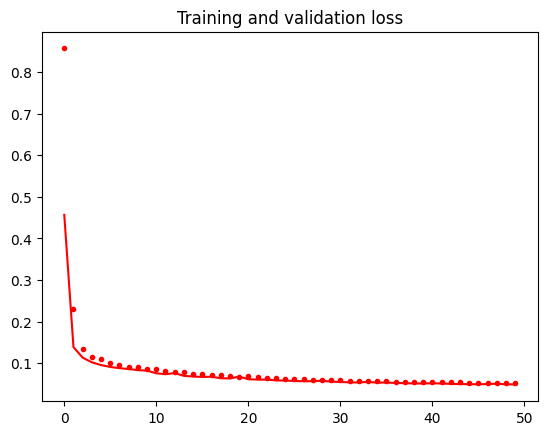

In [25]:
def plot_training(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(train_loss))
  
    plt.plot(epochs, train_loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()
    
plot_training(history)

In [27]:
import numpy as np
import librosa.display

def spec_plot(spectrogram, ax_index, title):
    print(f"Spectrogram shape before reshaping: {spectrogram.shape}")

    spectrogram_resized = np.resize(spectrogram, (1025, 216))

    librosa.display.specshow(librosa.amplitude_to_db(spectrogram_resized, ref=np.max), ax=ax[ax_index])
    ax[ax_index].set_title(title)



Spectrogram shape before reshaping: (1025, 216, 1)
Spectrogram shape before reshaping: (1025, 216, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Spectrogram shape before reshaping: (1, 1025, 216, 1)


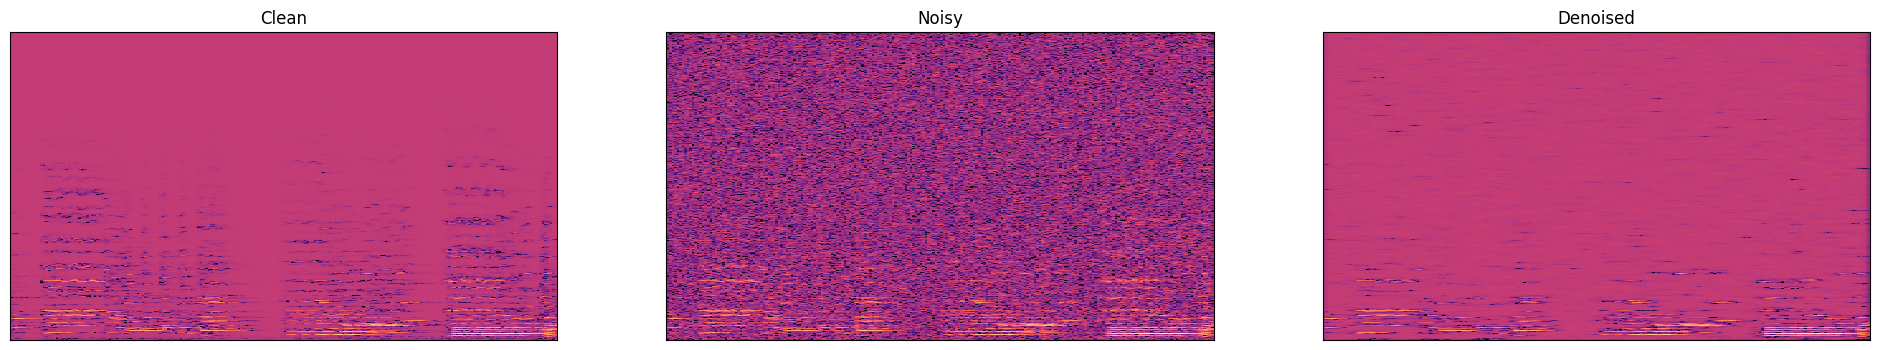

In [28]:
index = 10

fig, ax = plt.subplots(ncols=3, figsize = (24,4))
clean = y_test[index]
spec_plot(clean, 0, 'Clean')
noisy = x_test[index]
spec_plot(noisy, 1, 'Noisy')
denoised = autoencoder.predict(np.reshape(noisy, (1, noisy.shape[0], noisy.shape[1], 1)))
spec_plot(denoised, 2, 'Denoised')

plt.show()

In [71]:
spec = N.denormalize(clean.reshape(spec_shape))
spec_inv = librosa.griffinlim(spec)
soundfile.write('clean.wav', spec_inv, 16000)

spec = N.denormalize(noisy.reshape(spec_shape))
spec_inv = librosa.griffinlim(spec)
soundfile.write('noisy.wav', spec_inv, 16000)

spec = N.denormalize(denoised.reshape(spec_shape))
spec_inv = librosa.griffinlim(spec)
soundfile.write('denoised.wav', spec_inv, 16000)

In [72]:
ipd.Audio('clean.wav')

In [73]:
ipd.Audio('noisy.wav')

In [74]:
ipd.Audio('denoised.wav')

In [58]:
autoencoder.save('denoisingAudio5sec2.h5')

In [60]:
autoencoder.save_weights("denoisingAudio5sec2.weights.h5")

In [61]:
autoencoder.save('denoisingAudio5sec2.keras')

In [ ]:
predictions = autoencoder.predict(x_test)

x_test_denorm = N.denormalize(x_test)
y_test_denorm = N.denormalize(y_test)
predictions_denorm = N.denormalize(predictions)

def calculate_psnr(clean, denoised):
    mse = np.mean((clean - denoised) ** 2)
    if mse == 0:
        return 100  
    max_pixel = 1.0  
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

psnr_values = [calculate_psnr(y_test_denorm[i], predictions_denorm[i]) for i in range(len(y_test))]


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


In [82]:
print(f"Average PSNR: {np.mean(psnr_values):.2f} dB")

Average PSNR: 31.79 dB


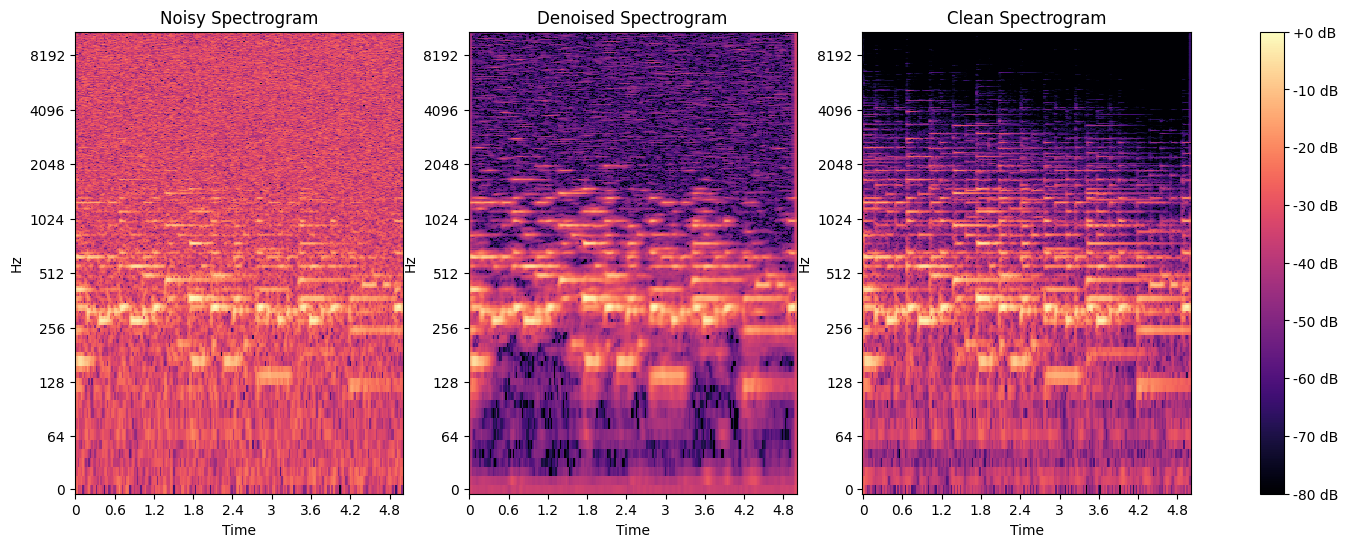

In [90]:
idx = random.randint(0, len(y_test) - 1)

fig, ax = plt.subplots(ncols=3, figsize=(18, 6))

noisy_img = librosa.display.specshow(librosa.amplitude_to_db(x_test_denorm[idx, :, :, 0], ref=np.max),
                                     y_axis='log', x_axis='time', ax=ax[0])
ax[0].set_title('Noisy Spectrogram')

denoised_img = librosa.display.specshow(librosa.amplitude_to_db(predictions_denorm[idx, :, :, 0], ref=np.max),
                                        y_axis='log', x_axis='time', ax=ax[1])
ax[1].set_title('Denoised Spectrogram')

clean_img = librosa.display.specshow(librosa.amplitude_to_db(y_test_denorm[idx, :, :, 0], ref=np.max),
                                     y_axis='log', x_axis='time', ax=ax[2])
ax[2].set_title('Clean Spectrogram')

fig.colorbar(clean_img, ax=ax, format="%+2.0f dB", location="right")
plt.show()

In [91]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

def signal_to_noise_ratio(y_true, y_pred):
    epsilon = 1e-8
    signal_energy = np.sum(y_true ** 2)
    noise_energy = np.sum((y_true - y_pred) ** 2)
    return 10 * np.log10(signal_energy / (noise_energy + epsilon))

def stft_loss(S_clean, S_pred):
    return np.mean(np.abs(S_clean - S_pred))

In [92]:
snr = [signal_to_noise_ratio(y_test_denorm[i], predictions_denorm[i]) for i in range(len(y_test))]

stft_metric = [stft_loss(np.fft.fft2(y_test_denorm[i]), np.fft.fft2(predictions_denorm[i]))  for i in range(len(y_test))]

In [100]:
print(f"Signal-to-Noise Ratio (SNR): {snr:.4f} dB")
print(f"STFT Loss: {stft_metric:.4f}")

Signal-to-Noise Ratio (SNR): 21.2121 dB
STFT Loss: 0.0585
